# Gaussian Process error

## N-point Green's functions

In [2]:
import numpy as np

from qutip import *
from qutip.qip.operations import rx
from pylab import *

import functools

In [260]:
def greens_plot(num_points, meas, corr_vec):
    f, a = plt.subplots(1, len(meas), sharex=True, sharey=True, figsize=(8 * len(meas), 6))
    for idx, (k, _) in enumerate(meas.items()):
        corr_vec = corr_vec_d[k]
        for corr in corr_vec:
            a[idx].plot(tlist, np.real(corr), alpha=0.5)
        a[idx].plot(tlist, np.mean(np.real(corr_vec), axis=0), 'r+', label='mean')

        a[idx].set_xlabel(r'$\tau$')
        a[idx].set_ylabel(fr'{num_points}-point correlation')

        title = fr'Correlation $\left<{k}(t + \tau), {k}(t)\right>$' if num_points == 2 else fr'Correlation $\left<{k}(t), {k}(t + \tau), {k}(t)\right>$'
        a[idx].set_title(title)

    f.legend()
    f.show()

In [6]:
# Classical stochastic parameterization of sigmax() rotation.
def gaussian_process(prev, i, mu, sigma, T):
    if i > T:
        return prev
    i += 1
    prev.append(np.random.normal(mu, sigma) * sigmax())
    return gaussian_process(prev, i, mu, sigma, T)

# Cached.
def hamiltonian(gp, t, *args):
    # t is rounded since we're working on the lattice.
    t = int(t)
    return gp[t]

# Prepare in sigmaz().
state0 = basis(2, 0)
# Hermitian observables.
meas = {
    r'\sigma_X': sigmax(),
    r'\sigma_Y': sigmay(), # optimal
    r'\sigma_Z': sigmaz(),
#     r'\frac{1}{\sqrt{2}}(\sigma_X + \sigma_Y)': (sigmax() + sigmay() ) / np.sqrt(2),
}

# Number of independent GP chains to sample.
M = 100
# Lattice size (temporal)
T = 10
# Maximum temporal radius on lattice to compute two-point correlations.
TAU_MAX = 10
tlist = np.linspace(0, TAU_MAX - 1, TAU_MAX, dtype=np.int)

In [271]:
MU = 0
SIGMA = np.pi / 18

NUM_POINTS = 2
assert NUM_POINTS == 2 or NUM_POINTS == 3, "Green's must be 2- of 3-point."

expected_random_2sd_distance = np.sqrt(2 * SIGMA * 2 * T / np.pi)
assert expected_random_2sd_distance < np.pi/2, f"Random walk distance should remain bounded to hemisphere: expected {expected_random_2sd_distance} < {np.pi/2}"

def get_greens(m, num_points=2):
    corr_vec = []
    for i in range(M):
        # Sample GP.
        gp = gaussian_process([qeye(2)], 0, MU, SIGMA, 2 * T)
        h = functools.partial(hamiltonian, gp)
        greens = correlation_2op_1t if num_points == 2 else functools.partial(correlation_3op_1t, c_op=m)
        # Compute two-points.
        corr_vec.append(
            greens(H=h, state0=state0, taulist=tlist, c_ops=[Qobj([[0.0, 0.0],[0.0, 0.0]])], a_op=m, b_op=m)
        )
    return corr_vec

corr_vec_d = {}
for k, v in meas.items():
    corr_vec_d[k] = get_greens(v, num_points=NUM_POINTS)


In [306]:
theta = np.pi / 5

green_2 = lambda sigmai: rx(theta) * sigmai * rx(theta).dag() * sigmai * state0 * state0.dag()
green_3 = lambda sigmai: sigmai * green_2(sigmai)

print(green_2(sigmaz()).tr(), "\n")
print(green_2(sigmay()).tr(), "\n")

# Commutes with prepared state.
print(green_3(sigmaz()), "\n")
print((green_3(sigmaz())).tr(), "\n")
# Does not commute. Hence, distinction becomes apparent at 3-point.
print(green_3(sigmay()), "\n")
print((green_3(sigmay())).tr(), "\n")

0.8090169943749473 

0.8090169943749473 

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.80901699+0.j         0.        +0.j        ]
 [0.        +0.58778525j 0.        +0.j        ]] 

0.8090169943749473 

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-0.58778525+0.j          0.        +0.j        ]
 [ 0.        +0.80901699j  0.        +0.j        ]] 

-0.587785252292473 



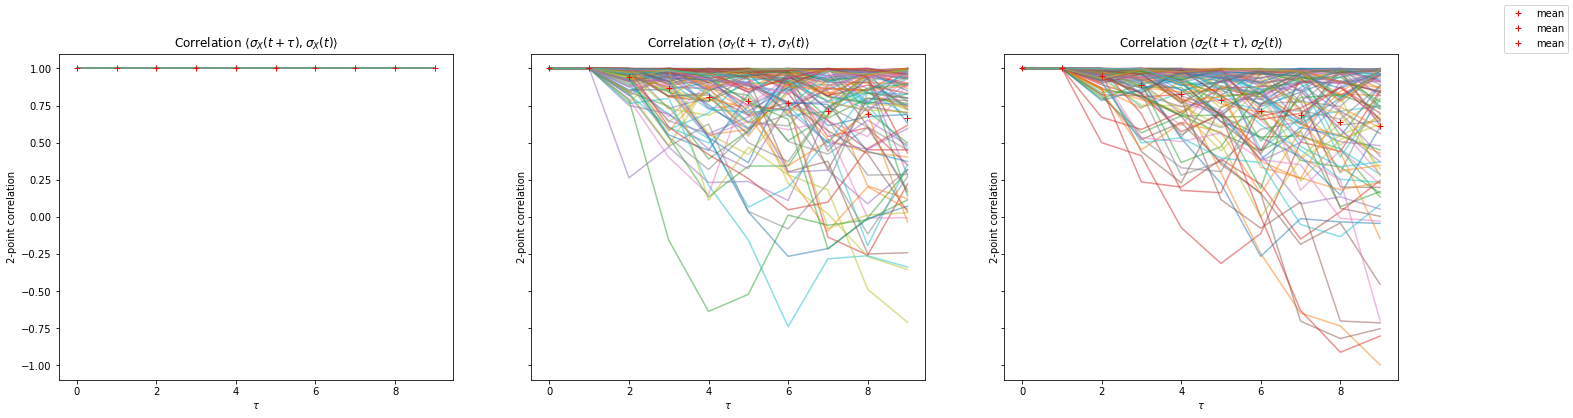

In [272]:
greens_plot(NUM_POINTS, meas, corr_vec)

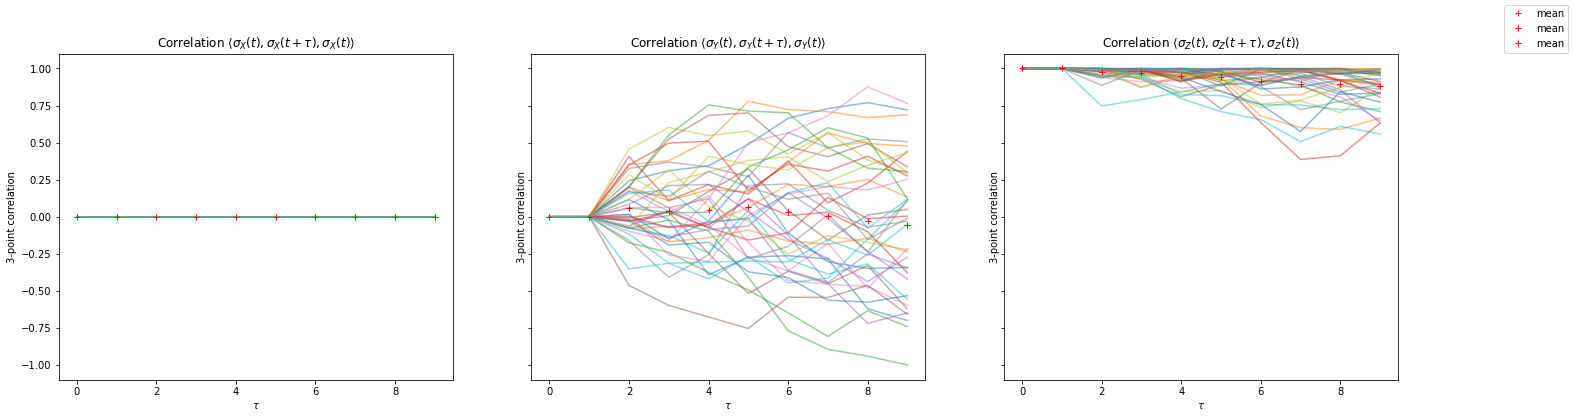

In [256]:
greens_plot(NUM_POINTS, meas, corr_vec)

## Keldysh

In [3]:
import itertools

In [ ]:
# Temporal lattice size.
T = 3
# Prepare in sigmaz().
state0 = basis(2, 0)
# Number of independent GP chains to sample.
M = 5

def generate_contour_trajectories(m):
    r = []
    
    sgn = np.sign(m)
    sgn = 1 if sgn == 0 else sgn
    for m_L in range(0, sgn * (2 * T + 1), sgn):
        m_R = 2*m - m_L
        r.append((m_L, m_R))
    return r
            

def keldysh_qprob(observable_spectra, m, H):
    assert m <= T
    ms = generate_contour_trajectories(m)
    q_prob = 0.0
    
    def integer_division(a, b):
        return -(-a // b) if a < 0 else a // b
    for m_L, m_R in ms:
        l_ones = T + integer_division(m_L, 2)
        l_zeros = T - integer_division(m_L, 2)
        if math.fmod(m_L, 2) < 0:
            l_zeros += 1
        elif math.fmod(m_L, 2) > 0:
            l_ones += 1
            
        r_ones = T + integer_division(m_R, 2)
        r_zeros = T - integer_division(m_R, 2)
        if math.fmod(m_R, 2) < 0:
            r_zeros += 1
        elif math.fmod(m_R, 2) > 0:
            r_ones += 1
        
        l_path = np.append(np.ones(l_ones, dtype=np.int), np.zeros(l_zeros, dtype=np.int))
        r_path = np.append(np.ones(r_ones, dtype=np.int), np.zeros(r_zeros, dtype=np.int))
        
        for l_perm in set(itertools.permutations(l_path, r=len(l_path))):
            for r_perm in set(itertools.permutations(r_path, r=len(r_path))):
                if l_perm[-1] != r_perm[-1]:
                    continue
                
                base_prob = observable_spectra[l_perm[0]].dag() * state0 * state0.dag() * observable_spectra[r_perm[0]]
                A_L = 1.0
                A_R = 1.0
                for i in range(2 * T - 1):
                    eig_l_ket = observable_spectra[l_perm[i]]
                    eig_l_bra = observable_spectra[l_perm[i+1]].dag()
                    A_L *= eig_l_bra * (-1j * H(i)).expm() * eig_l_ket
                    
                    eig_r_ket = observable_spectra[r_perm[i]]
                    eig_r_bra = observable_spectra[r_perm[i+1]].dag()
                    A_R *= eig_r_bra * (-1j * H(i)).expm() * eig_r_ket
                q_prob += A_L * A_R.dag() * base_prob
    return q_prob


# Sample GP.
SIGMA = np.pi / 10
MU = 0
gp = gaussian_process([], 0, MU, SIGMA, 2 * T)
h = functools.partial(hamiltonian, gp)

# Hermitian observables.
meas = {
    r'\sigma_X': sigmax(),
    r'\sigma_Y': sigmay(), # optimal
    r'\sigma_Z': sigmaz(),
#     r'\frac{1}{\sqrt{2}}(\sigma_X + \sigma_Y)': (sigmax() + sigmay() ) / np.sqrt(2),
}

ms = list(itertools.product(range(T), [1, -1]))
ms = set(map(lambda z: z[0] * z[1], ms))
keldysh_vec = {}

# np.sqrt(2SD * 2 * lattice_length / np.pi)
expected_random_2sd_distance = np.sqrt(2 * SIGMA * 2 * (2 * T) / np.pi)
assert expected_random_2sd_distance < np.pi/2, f"Random walk distance should remain bounded to hemisphere: expected {expected_random_2sd_distance} < {np.pi/2}"
for m, v in meas.items():
    qdist = []
    for iteration in range(M):
        qd_i = []
        for i in ms:
            qd_i.append(keldysh_qprob(v.eigenstates()[1], i, h))
        qdist.append(qd_i)
    keldysh_vec[m] = qdist


In [ ]:
def keldysh_plot(meas, keldysh_vec):
    f, a = plt.subplots(1, len(meas), sharex=True, sharey=True, figsize=(8 * len(meas), 6))
    for idx, (k, _) in enumerate(meas.items()):
        cv = keldysh_vec[k]
        corr_vec = [[None] * len(cv[0])] * len(cv)
        for i in range(len(cv)):
            for j in range(len(cv[0])):  
                corr_vec[i][j] = np.real((np.array(cv[i][j])).flatten())
        for corr in corr_vec:
            a[idx].scatter(ms, corr, alpha=0.5)
        
        a[idx].plot(ms, np.mean(corr_vec, axis=0), 'r+', label='mean')
        title = fr'KQPD ${k}$'
        a[idx].set_title(title)

    f.legend()
    f.show()

In [ ]:
keldysh_plot(meas, keldysh_vec)